# 7. Botnet fingerprinting task

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

## Load the profiles

In [24]:
# reuse this module
from profiling import profile_scenario

selected_scenarios = [9, 10, 11, 12]

ip_ngrams_per_scene= {}
for scene in selected_scenarios:
    ip_ngrams_per_scene[scene] = profile_scenario('data/utils/discretized_scenario_'+str(scene)+'.csv')

100%|██████████| 23/23 [00:00<00:00, 151.26it/s]


In [25]:
import pickle
# read label encoder to convert encoded IPs to string

SrcAddr_LabelEncoder_per_scene= {}
for scene in selected_scenarios:
    SrcAddr_LabelEncoder_per_scene[scene] = pickle.load(open('./data/utils/SrcAddr_LabelEncoder_'+str(scene)+'.pkl', 'rb'))


try:
    for scene in selected_scenarios:
        keys = list(ip_ngrams_per_scene[scene].keys())
        ip_keys = list(SrcAddr_LabelEncoder_per_scene[scene].inverse_transform(keys))
        for i in range(len(ip_keys)):
            ip_ngrams_per_scene[scene][ip_keys[i]] = ip_ngrams_per_scene[scene].pop(keys[i])
finally:
    print('Labelled dictionary by IP and not discretised value :)')


Labelled dictionary by IP and not discretised value :)


## Segment the IPs per scene and infected vs benign

we use the readmes from each dataset to get these IPs

In [27]:
# identify 1 infected IP  for training
train_infected_IPs_per_scene = {
    9: '147.32.84.165',
    10: '147.32.84.165',
    11: '147.32.84.165',
    12: '147.32.84.165'
}   

# identify other infected IPs for tuning the threshold
infected_IPs_per_scene = {
    9: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
        ],

    10: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
    ],

    11: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192'
    ],

    12: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
    ]
} 

# find all IPs for each scenario
all_IPs_per_scene = {
    9: list(ip_ngrams_per_scene[9].keys()),
    10: list(ip_ngrams_per_scene[10].keys()),
    11: list(ip_ngrams_per_scene[11].keys()),
    12: list(ip_ngrams_per_scene[12].keys()),
}

for scene in selected_scenarios:
    all_IPs_per_scene[scene].remove(train_infected_IPs_per_scene[scene])

benign_IPs_per_scene = {
    9: list(set(ip_ngrams_per_scene[9].keys()) - (set(infected_IPs_per_scene[9]) | set(train_infected_IPs_per_scene[9]))),
    10: list(set(ip_ngrams_per_scene[10].keys()) - (set(infected_IPs_per_scene[10]) | set(train_infected_IPs_per_scene[9]))),
    11: list(set(ip_ngrams_per_scene[11].keys()) - (set(infected_IPs_per_scene[11]) | set(train_infected_IPs_per_scene[9]))),
    12: list(set(ip_ngrams_per_scene[12].keys()) - (set(infected_IPs_per_scene[12]) | set(train_infected_IPs_per_scene[9]))),
}

## Fingerprinting task

- We iterate through scenarios
- For each scenario, we iterate through all the IPs(benign + malicious)
- For each of these IPs, we check if any of the ngram sequences in any window is not present in any of the benign profiles. If this is the case, we deem the IP to be malicious. (Actually, we would like to keep a count of "benign" ngram sequences found for each IP)
- We can then visualize these counts to see how accurate this is

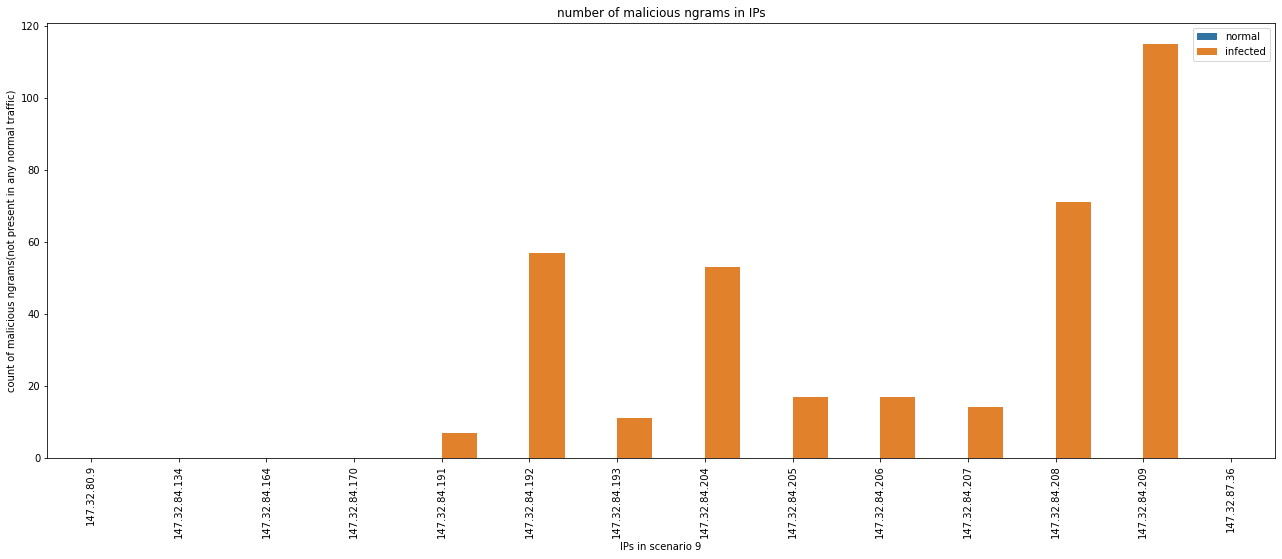

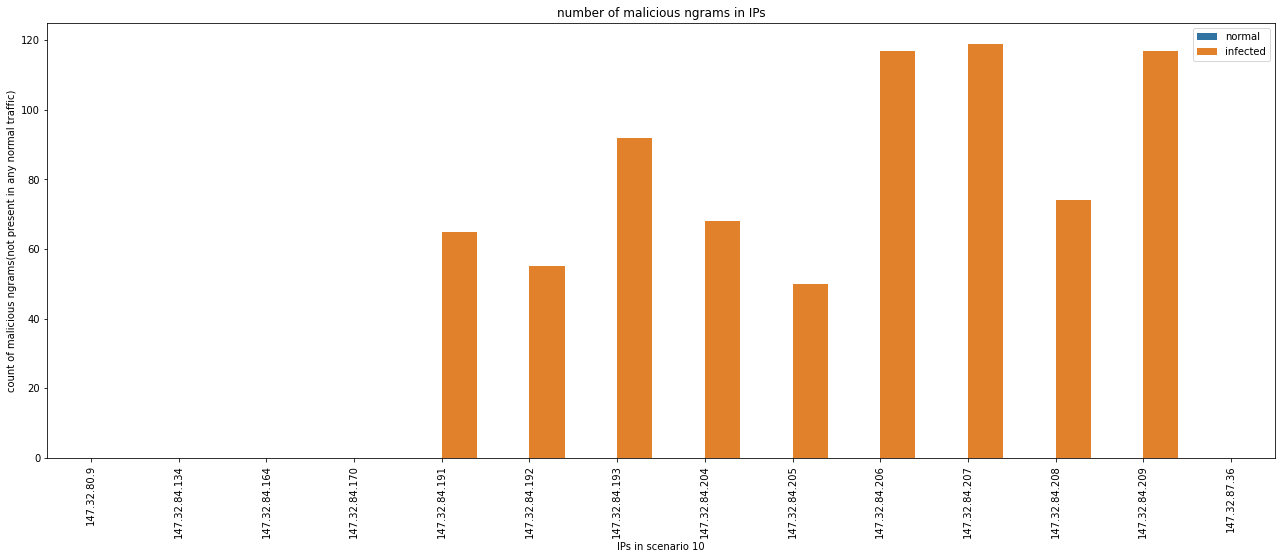

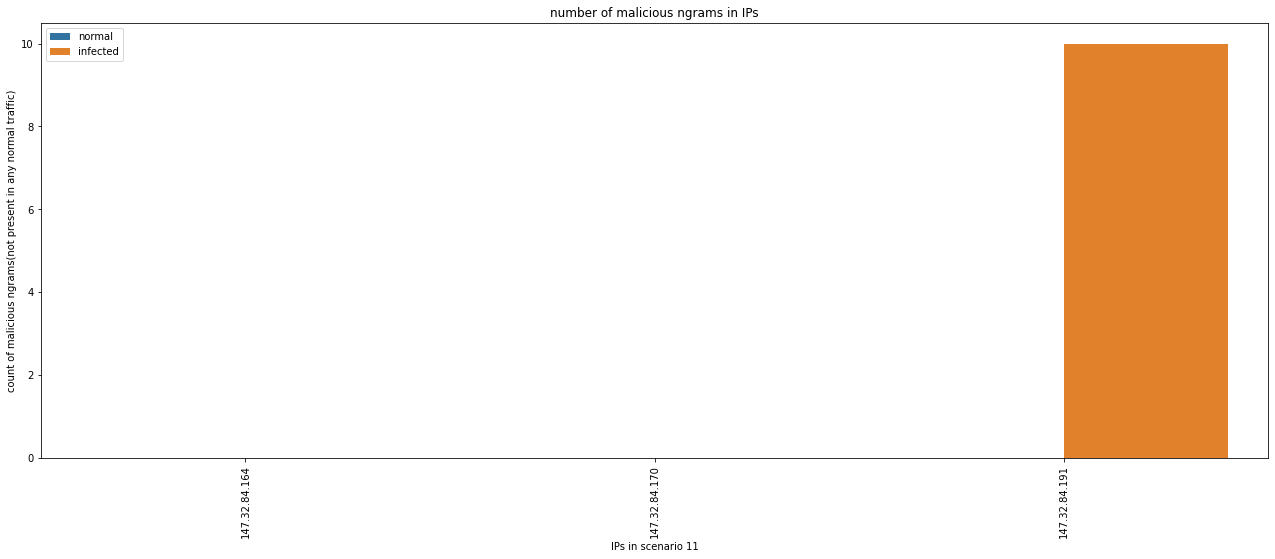

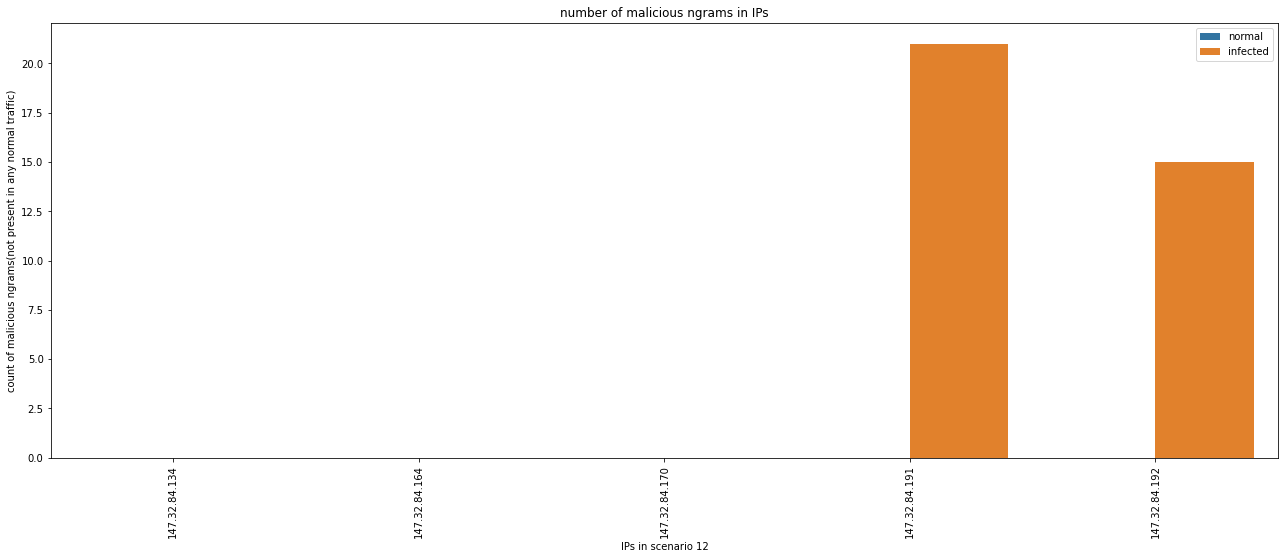

In [112]:
for scenario in selected_scenarios:
    benign_ngrams = [ip_ngrams_per_scene[scenario][benign_ips] for benign_ips in benign_IPs_per_scene[scenario]]
    benign_ngrams = np.concatenate(benign_ngrams)
    ip_malicious_ngram_counts = {}
    for ip in all_IPs_per_scene[scenario]:
        ip_malicious_ngram_counts[ip] = 0
        for i, ngram_seq in enumerate(ip_ngrams_per_scene[scenario][ip]):
            if not any(np.equal(benign_ngrams, ngram_seq).all(1)):
                ip_malicious_ngram_counts[ip] += 1
    ips = []
    counts = []
    infected = []
    for ip, count in ip_malicious_ngram_counts.items():
        ips.append(ip)
        counts.append(count)
        infected.append("infected" if ip in infected_IPs_per_scene[scenario] else "normal")
    
    f, ax = plt.subplots(1, 1, figsize =(22, 8))
    sns.barplot(x=ips, y=counts, hue=infected, ax=ax)
    ax.set_xticklabels(ips, rotation=90)
    ax.set_title(f"number of malicious ngrams in IPs from scenarion {scenario}")
    ax.set_xlabel(f"IPs in scenario {scenario}")
    ax.set_ylabel("count of malicious ngrams(not present in any normal traffic)")
    ax.legend()
    plt.show()

## Analysis and answers to the questions.

**Evaluate how many new infections your method finds and false positives it raises (as in paper 4). Compare it to profiling and explain the results**

In the plots, we can see the different IPs in scenarios 9, 10, 11 and 12 on the x axis. The y axis represents the counts of ngram sequences that were malicious. We can see the two kinds bars, orange (infected) and blue(benign). We can see that the fingerprinting captures all infected IPs while none of the normal IPs.

Based on the results obtained using profiling and fingerprinting, we can now make a comparison between the two. We see that both methods are a bit overly simplistic. The fingerprinting does not give us any new infections other than the labels